<h1>Baysian Analysis</h1>
<p>The following notebook performs a Bayseian analysis on the existing data by calcuating the Prior distribution from a decade and a half of goalie season data and then using it (and the congugate pairing) to estimate the Posterior distribution in the hopes of illuminating the uncertainty surrounding goalies with a variety of shots against them.</p>

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
from matplotlib import pyplot as plt
import seaborn as sns
import sqlite3
import scipy.stats as stats
import pymc3 as pm
%matplotlib inline
from IPython.core.pylabtools import figsize

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [2]:
DB = "..\\Data\\hockey_data_goalies.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

<h2>Determine the Prior Distribution</h2>
<p>Get the data for 15 seasons and then fit it to a beta distribution to determine a and b (the beta distribution parameters)</p>

In [3]:
def season_finder(date):
    """
    Finds the season (YYYY-YYYY+1) given the date in datetime format
    """
    if date.month > 8:
        return date.year
    else:
        return date.year-1
 

#get player logs for the last 15 years

q = """SELECT * 
        FROM player_log 
        WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {0}
        AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {1}
        """.format(2000.66,2015.66)
games = run_query(q)
games['date_game'] = games['date_game'].astype('datetime64') #convert to datetime
games['time_on_ice'] = games['time_on_ice'].str.extract(r'(\d*)\:\d*')[0].astype(int)+games['time_on_ice'].str.extract(r'\d*\:(\d*)')[0].astype(int)/60
games['season'] = games['date_game'].map(lambda x: season_finder(x))
gamesgb = games.groupby(['player_id','season']).sum()
#remove players who've played less than 60 minutes in a season
gamesgb = gamesgb[gamesgb['time_on_ice']>120]
gamesgb['save_pct'] = gamesgb['saves']/gamesgb['shots_against']

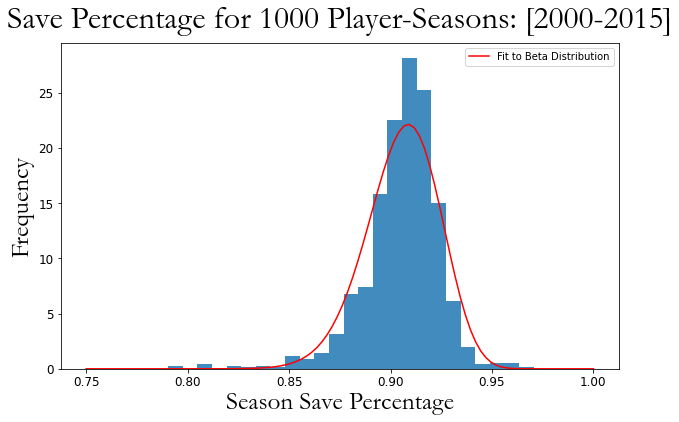

In [10]:
#this is the historic save percentages for the 15 years 2000-2015
data = gamesgb['save_pct'].to_list()

bin_no = 25

#fit the historic distribution to a beta distribution
a,b,loc,scale = stats.distributions.beta.fit(data,floc=0,fscale=1)

#print(a,b,loc,scale)

x = np.linspace(0.75,1,100)


fitted_data = stats.distributions.beta.pdf(x,a,b,loc,scale)
plt.figure(figsize=[10,6])
plt.hist(gamesgb['save_pct'].to_list(), bins = bin_no,density=True,alpha =.85)
plt.plot(x,fitted_data,'r-',label='Fit to Beta Distribution')
plt.xlabel('Season Save Percentage',font='Garamond',fontsize=25)
plt.ylabel('Frequency',font='Garamond',fontsize=25)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
ttl = plt.title('Save Percentage for 1000 Player-Seasons: [2000-2015]',font='Garamond',fontsize=32,pad = 15)
plt.legend()
plt.savefig('HistoricDistribution.png')
plt.show()

In [5]:
#Look at one team for one particular season and determine the posterior distribution
q = """SELECT pl.player,log.*
        FROM player_log log
        LEFT JOIN player_list pl ON pl.unique_id= log.player_id
        WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {0}
        AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {1}
        AND team_id ="TOR"
        """.format(2016.66,2017.66)
tor = run_query(q)
tor['time_on_ice'] = tor['time_on_ice'].str.extract(r'(\d*)\:\d*')[0].astype(int)+tor['time_on_ice'].str.extract(r'\d*\:(\d*)')[0].astype(int)/60

In [6]:
#the goalie end of year results
torgb = tor.groupby('player').sum()
torgb['Save %'] = np.round(torgb['saves']/torgb['shots_against'],3)
torgb['Minutes (Season)'] = (np.round(torgb['time_on_ice'],0)).astype(int)
#torgb.iloc[:,[2,3,7,4]]
torgb.iloc[:,[11,10]]

,Minutes (Season),Save %
player,,
Curtis McElhinney,759,0.914
Frederik Andersen,3799,0.918
Jhonas Enroth,274,0.872


<h2>Posterior Distribution</h2>
<p>Since the conjugate prior of the beta distribution (for a bernoulli type likelihood) is another beta distribution we can easily calculate the postierior, otherwise we'd have to do something like a markov chain monte carlo.</p>
<p>nicely the new a = a + the number of saves and the new b = b + the number of goals allowed</p>
<p>Still, we validate via a monte carlo against the historic season to determine changes in allowed goals vs simulated goals</p>

In [11]:
x = np.linspace(0.75,1,100)
plt.figure(figsize=[10,6])
for i in torgb.index:
    plt.plot(x,stats.distributions.beta.pdf(x,a+torgb.loc[i,'saves'],b+torgb.loc[i,'goals_against'],loc,scale),label=i)
plt.plot(x,fitted_data,'r-',label='Fit to Beta Distribution')
plt.xlabel('Adjusted Save Percentage',font='Garamond',fontsize=25)
plt.ylabel('Frequency',font='Garamond',fontsize=25)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
ttl = plt.title('Posterior Save Percentage Given Recent Shot Load',font='Garamond',fontsize=32,pad = 15)
plt.legend(fontsize=18)
plt.savefig('InferredSavePercentage.png')
plt.show()


NameError: name 'torgb' is not defined

<Figure size 720x432 with 0 Axes>

In [8]:
def goaliemc(team,year):
    """
    Run a monte carlo to determine impact of these distributions
    """
    a = 231.14
    b = 24.2
    
    #pick a player for the season...
    q = """SELECT pl.player,log.*
        FROM player_log log
        LEFT JOIN player_list pl ON pl.unique_id= log.player_id
        WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {0}
        AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {1}
        AND team_id ="TOR"
        """.format(2016.66,2017.66)

In [9]:
date = '2017-01-21'
team = 'TOR'
year = 2016
#we're using the a and b from the fit
a = 231.14
b = 24.2
loc=0
scale=1
#get team stats for the season in question
q = """SELECT *
    FROM team_log
    WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {1}
    AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {2}
    AND team_id ="{0}"
    """.format(team,year+.66,year+1.66)
#
games = run_query(q)
pregames = games[games['date_game']<date]
no_games = pregames.shape[0]
games_won = print((pregames['game_outcome']=='W').sum())

21


In [34]:
# this code calculates a mc against the full season for the 2016 leafs
q = """SELECT *
    FROM team_log
    WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {1}
    AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {2}
    AND team_id ="{0}"
    """.format(team,year+.66,year+1.66)
games = run_query(q)
pregames = games[games['date_game']<date]
no_games = pregames.shape[0]
max_shots = pregames['shots_against'].max()
games_won = (pregames['game_outcome']=='W').sum()
for play in torgb.index:
    result = 0
    wins = 0
    tot_mc = int(10000/no_games) #montecarlo with 50000 games
    for x in range(tot_mc):
        saves = stats.distributions.beta.rvs(231.14+torgb.loc[play,'saves'],24.2+torgb.loc[play,'goals_against'],0,1,[no_games,max_shots])
        shots = np.random.random((no_games,max_shots))
        goals = (saves<shots)
        for i in range(pregames.shape[0]):
            gr = goals[i,:pregames.at[i,'shots_against']].sum()
            result += gr-pregames.at[i,'opp_goals']
            if (pregames.at[i,'goals']-gr)>0:
                wins += 1
    print(play,wins)
    print("%s allows %0.2f more goals per game resulting in %d more wins" % (play,result/(10000),wins/(tot_mc)-games_won))

Curtis McElhinney 4579
Curtis McElhinney allows -0.03 more goals per game resulting in -1 more wins
Frederik Andersen 4968
Frederik Andersen allows -0.23 more goals per game resulting in 0 more wins
Jhonas Enroth 3776
Jhonas Enroth allows 0.53 more goals per game resulting in -4 more wins
